# General Purpose Defect Inspection
## Experiment with different models using a dataset of M&Ms to detect various defects. 

In [1]:
import keras
import keras_metrics as km
from keras.models import Sequential,load_model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, average_precision_score
from tqdm import tqdm
from inspect import signature
from itertools import cycle
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image

Using TensorFlow backend.


### Read the labels, set the directory.

In [2]:
# directory of M&M images
img_dir = 'newmm/crop_mm'
# the label csv file
df=pd.read_csv('newmm/crop_mm_relabel.csv')
# columns are the labels, or type of defects.
columns=df.columns.tolist()[1:] 

# What the labels look like, 1 --> defect is present.
# partialm means the letter "M" isn't printed in whole, or partially missing.
# offcenterm means the letter "M" isn't on the center of button.
# bad shape means the button isn't round, has a weird shape.
# bad surface means there are surface blemish, e.g. chips, etc.
df.head()

,External ID,partialm,offcenterm,badshape,badsurface
0,IMG756.jpg,0,0,0,0
1,IMG20.jpg,0,0,1,1
2,IMG788.jpg,0,0,0,0
3,IMG52.jpg,0,0,1,1
4,IMG820.jpg,1,0,0,0


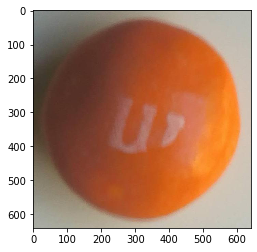

In [3]:
# Open an image and see what it looks like. 
# Notice a corner of the "M" letter is missing, otherwise it "looks" fine, thus labeled (1, 0, 0, 0).
img=mpimg.imread('newmm/crop_mm/IMG820.jpg')
plt.imshow(img)

### Create train, validation and test generators with 80-10-10 split

In [4]:
# Downsample the images to 160x160
image_size = 160
batch_size = 16

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip=True,rotation_range=180)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow_from_dataframe(
dataframe=df[:round(df.shape[0]*0.8)],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=batch_size,
seed=1,
shuffle=True,
class_mode="other",
target_size=(image_size,image_size))

Found 1069 validated image filenames.


In [6]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[round(df.shape[0]*0.8):round(df.shape[0]*0.9)],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=batch_size,
shuffle=False,
class_mode="other",
target_size=(image_size,image_size))

Found 133 validated image filenames.


In [7]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=df[round(df.shape[0]*0.9):],
directory=img_dir,
x_col="External ID",
y_col=columns,
batch_size=1,
shuffle=False,
class_mode="other",
target_size=(image_size,image_size))

Found 134 validated image filenames.


### Get step size per epoch

In [8]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

### Create log dir for tensorboard visualization

In [9]:
if not os.path.exists('my_log_dir/'):
    os.makedirs('my_log_dir/')

## Build a CNN of a few conv blocks, train from scratch


### Create callbacks to optimize training

In [10]:
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='val_acc',
patience=30,
),
keras.callbacks.ModelCheckpoint(
filepath='mm_scratch.h5',
monitor='val_acc',
save_best_only=True,
),
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.5,
patience=30,
),
keras.callbacks.TensorBoard(
log_dir='my_log_dir',
histogram_freq=0, write_graph=True,
)
]

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(len(columns), activation='sigmoid'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300,
                    callbacks=callbacks_list,
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
66/66 [==============================] - 13s 196ms/step - loss: 0.8561 - acc: 0.5419 - val_loss: 0.7995 - val_acc: 0.5762
Epoch 2/300
66/66 [==============================] - 11s 167ms/step - loss: 0.7445 - acc: 0.5737 - val_loss: 0.7766 - val_acc: 0.5833
Epoch 3/300
66/66 [==============================] - 11s 171ms/step - loss: 0.7016 - acc: 0.6080 - val_loss: 0.6276 - val_acc: 0.7094
Epoch 4/300
66/66 [==============================] - 11s 172ms/step - loss: 0.6704 - acc: 0.6265 - val_loss: 0.6161 - val_acc: 0.6709
Epoch 5/300
66/66 [==============================] - 11s 172ms/step - loss: 0.6330 - acc: 0.6531 - val_loss: 0.7161 - val_acc: 0.5919
Epoch 6/300
66/66 [==============================] - 11s 170ms/step - loss: 0.6171 - acc: 0.675

### No overfitting, learning curve is flatterning in the end

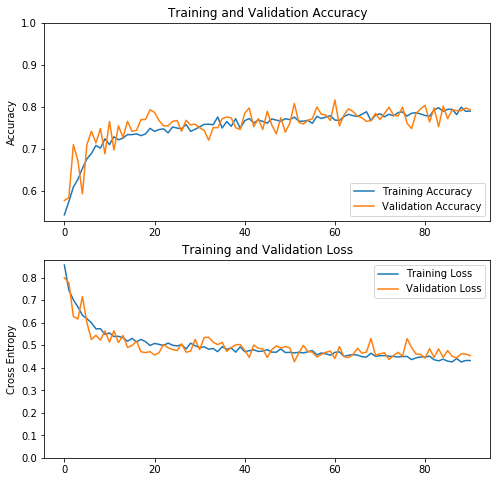

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model = load_model('mm_scratch.h5')

In [14]:
test_generator.reset()
test_loss, test_acc = model.evaluate_generator(test_generator, steps = STEP_SIZE_TEST)
print('test acc:', test_acc)

test acc: 0.8134328358208955


## Transfer learning with pre-trained network

In [15]:
callbacks_list = [
keras.callbacks.EarlyStopping(
monitor='val_acc',
patience=30,
),
keras.callbacks.ModelCheckpoint(
filepath='mm_transfer.h5',
monitor='val_acc',
save_best_only=True,
),
keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.5,
patience=30,
),
keras.callbacks.TensorBoard(
log_dir='my_log_dir',
histogram_freq=0, write_graph=True,
)
]

In [16]:
# Create the base model from the pre-trained model
base_model = keras.applications.InceptionV3(input_shape=(image_size, image_size, 3),
                                               include_top=False, 
                                               weights='imagenet')

base_model.trainable = False

model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(len(columns), activation='sigmoid')
])


model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [17]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300,
                    callbacks=callbacks_list,
)

Epoch 1/300
66/66 [==============================] - 13s 191ms/step - loss: 0.6714 - acc: 0.5847 - val_loss: 0.7961 - val_acc: 0.6261
Epoch 2/300
66/66 [==============================] - 10s 150ms/step - loss: 0.6229 - acc: 0.6301 - val_loss: 0.8363 - val_acc: 0.6068
Epoch 3/300
66/66 [==============================] - 11s 173ms/step - loss: 0.6239 - acc: 0.6228 - val_loss: 0.8192 - val_acc: 0.6197
Epoch 4/300
66/66 [==============================] - 11s 170ms/step - loss: 0.6173 - acc: 0.6336 - val_loss: 0.7995 - val_acc: 0.6289
Epoch 5/300
66/66 [==============================] - 11s 171ms/step - loss: 0.6179 - acc: 0.6327 - val_loss: 0.7648 - val_acc: 0.6325
Epoch 6/300
66/66 [==============================] - 11s 170ms/step - loss: 0.6150 - acc: 0.6286 - val_loss: 0.7502 - val_acc: 0.6218
Epoch 7/300
66/66 [==============================] - 11s 170ms/step - loss: 0.6013 - acc: 0.6478 - val_loss: 0.7405 - val_acc: 0.6175
Epoch 8/300
66/66 [==============================] - 11s 170ms

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [19]:
base_model.trainable = True
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
model.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy'])

In [20]:
history_fine = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=300,
                    callbacks=callbacks_list,
)

Epoch 1/300
66/66 [==============================] - 16s 237ms/step - loss: 0.5710 - acc: 0.6933 - val_loss: 0.5741 - val_acc: 0.6859
Epoch 2/300
66/66 [==============================] - 10s 153ms/step - loss: 0.5361 - acc: 0.7190 - val_loss: 0.5455 - val_acc: 0.7168
Epoch 3/300
66/66 [==============================] - 12s 175ms/step - loss: 0.5189 - acc: 0.7243 - val_loss: 0.4885 - val_acc: 0.7692
Epoch 4/300
66/66 [==============================] - 12s 175ms/step - loss: 0.5065 - acc: 0.7339 - val_loss: 0.5233 - val_acc: 0.7479
Epoch 5/300
66/66 [==============================] - 12s 176ms/step - loss: 0.4784 - acc: 0.7623 - val_loss: 0.5149 - val_acc: 0.7799
Epoch 6/300
66/66 [==============================] - 12s 175ms/step - loss: 0.4760 - acc: 0.7581 - val_loss: 0.5618 - val_acc: 0.7286
Epoch 7/300
66/66 [==============================] - 12s 175ms/step - loss: 0.4493 - acc: 0.7762 - val_loss: 0.5256 - val_acc: 0.7692
Epoch 8/300
66/66 [==============================] - 12s 174ms

Epoch 62/300
66/66 [==============================] - 12s 175ms/step - loss: 0.1283 - acc: 0.9493 - val_loss: 0.7824 - val_acc: 0.8013
Epoch 63/300
66/66 [==============================] - 12s 177ms/step - loss: 0.1262 - acc: 0.9534 - val_loss: 0.7765 - val_acc: 0.7991
Epoch 64/300
66/66 [==============================] - 12s 176ms/step - loss: 0.1216 - acc: 0.9579 - val_loss: 0.8228 - val_acc: 0.7863
Epoch 65/300
66/66 [==============================] - 12s 176ms/step - loss: 0.1189 - acc: 0.9523 - val_loss: 0.7122 - val_acc: 0.8027
Epoch 66/300
66/66 [==============================] - 12s 177ms/step - loss: 0.1160 - acc: 0.9563 - val_loss: 0.6574 - val_acc: 0.8226


In [21]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

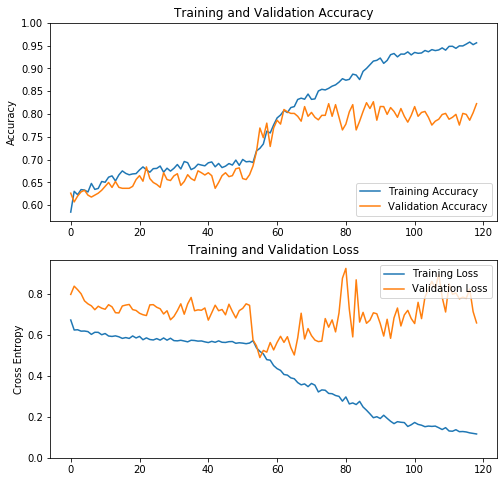

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model = load_model('mm_transfer.h5')

In [24]:
test_generator.reset()
test_loss, test_acc = model.evaluate_generator(test_generator, steps = STEP_SIZE_TEST)
print('test acc:', test_acc)

test acc: 0.7985074626865671


### Previously accuracy is  calculatred using 0.5 default threshold for all labels. Let's plot precision recall curve and fine tune threshold for each class of defects

In [25]:
test_generator.reset()
Y_test = np.asarray(df[round(df.shape[0]*0.9):][columns])
y_score = model.predict_generator(test_generator, steps =STEP_SIZE_TEST )


# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in tqdm(range(4)):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")


100%|██████████| 4/4 [00:00<00:00, 1766.95it/s]


In [26]:
# Adjust widget slider to set the threshold value
# Choose a threshold to land the (recall,precision) red marker on the "desired" region of PRC below
def f(threshold):
    return threshold
w = interact(f, threshold=(0.0,1.0, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

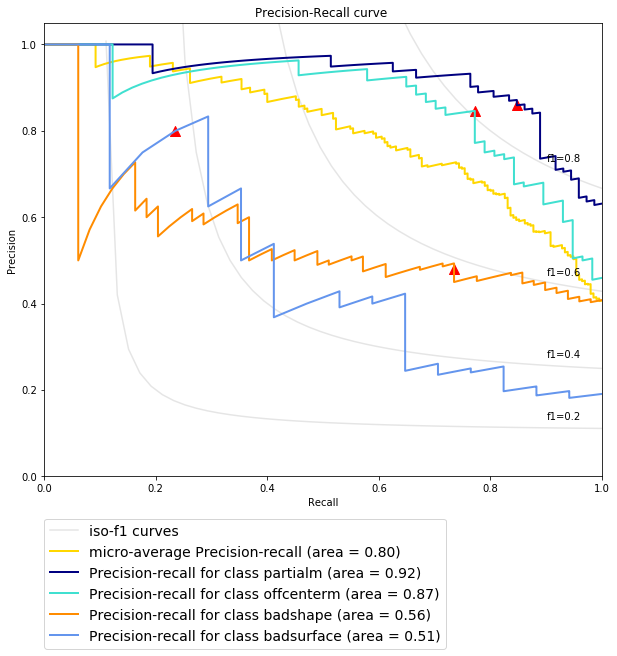

In [27]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(10, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(4), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {} (area = {})'.format(columns[i], round(average_precision[i],2)))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve ')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

thre = w.widget.result
y_pred = (y_score >= thre).astype(int)
recs = recall_score(Y_test, y_pred, average = None)
pres = precision_score(Y_test, y_pred, average = None)
plt.scatter(recs,pres,color = 'r', marker = '^', s = 100)

plt.show()

### Class "badsurface" is performing worse than the other three. 
### It's more difficult to detect as it often appears on the edge. Also as seen below, this class is unblanced. 
### Inceasing the number of samples with this particular defect will help. 
### If this is a critical defect, we can set a small threshold for this class. 
### Obviously there is a trade off between precision and recall. 
### A human inspector can second screen and overide the false positives to reduce impact on yield. 

In [28]:
# Assuming badsurface is a critial defect that we don't want to miss. If using threshold [0.5, 0.5, 0.5, 0.05].
# This is how much accuracy will be decrease due to increased false positive badsurface defects with low threshold
thre = [0.5, 0.5, 0.5, 0.05]
y_pred = (y_score >= thre).astype(int)
acc = np.sum((Y_test == y_pred).astype(int))/(Y_test.shape[0]*Y_test.shape[1])
acc

0.7947761194029851

<img src="class_distribution.png">

### Multiple Image inference with test dataset

In [29]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

134/134 [==============================] - 2s 18ms/step


In [30]:
pred_bool = (pred >0.5)

In [31]:
predictions = pred_bool.astype(int)
results=pd.DataFrame(predictions, columns=columns)
results["External ID"]=test_generator.filenames
ordered_cols=["External ID"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv("mm_result.csv",index=False)

### Single Image inference

In [32]:
#load and downsample the image
img = Image.open("newmm/crop_mm/IMG721.jpg")
img = img.resize((160,160), resample=Image.BICUBIC)
img = np.asarray(img)
img = np.expand_dims(img, 0)  
img = img/255.0
y = model.predict(img)

In [33]:
# predicated label [1,1,1,0]
y

array([[9.996064e-01, 9.998616e-01, 9.994392e-01, 3.772974e-05]],
      dtype=float32)

In [34]:
# Labels
df.iloc[-1]

External ID    IMG721.jpg
partialm                1
offcenterm              1
badshape                1
badsurface              1
Name: 1335, dtype: object

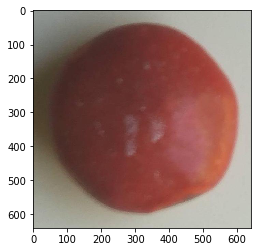

In [36]:
# it got the first three labels right, "M" letter is mostly missing, off centered and the shape is not round.
# but missed the bad surface which is labeled as 1 because of the hard to notice blemish on the bottom right
img=mpimg.imread('newmm/crop_mm/IMG721.jpg')
plt.imshow(img)

### References:
Deep Learning with Python by François Chollet

Tutorial on Keras ImageDataGenerator with flow_from_dataframe by Vijayabhaskar J